In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
from langchain_community.utilities import (
    arxiv, 
    wikipedia, 
    duckduckgo_search
)

from langchain_community.tools import (
    ArxivQueryRun, 
    WikipediaQueryRun, 
    DuckDuckGoSearchRun
)

## Setting Up Tools

# 1. Arxiv Research Tool
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv.ArxivAPIWrapper())

# 2. Wikipedia Search Tool
wiki_tool = WikipediaQueryRun(api_wrapper=wikipedia.WikipediaAPIWrapper())

# 3. DuckDuckGo Search
duckduckgo_tool = DuckDuckGoSearchRun(api_wrapper=duckduckgo_search.DuckDuckGoSearchAPIWrapper())


In [3]:
from langchain_community import utilities
print(dir(utilities))


['Any', 'REMOVED', 'TYPE_CHECKING', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__getattr__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_module_lookup', 'arxiv', 'duckduckgo_search', 'importlib', 'wikipedia']


In [4]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100 films, and earned numerous accolades, including 14 Filmfare Awards. He has been awarded the Padma Shri by the Government of India, as well as the Order of Arts and Letters and Legion of Honour by the Government of France. Khan has a significant following in Asia and the Indian diaspora worldwide. In terms of audience size and income, several media outlets have described him as one of the most successful film stars in the world. Many of his films thematise Indian national identity and connections with diaspora communities, or gender, racial, social and religious differences and grievances.\nKhan began his career with appearances in several television series in the late 1980s and made his 

In [5]:
# duckduckgo_tool.invoke("who is Sharukh Khan")

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [7]:
## List of All Tools
tools = [
    arxiv_tool
]

In [8]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [9]:
from langgraph.graph import StateGraph,START,END

In [10]:
graph_builder= StateGraph(State)


In [11]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
langsmith=os.getenv('LANGCHAIN_API_KEY')

In [ ]:
llm = ChatGroq(groq_api_key=groq_api_key, model="mixtral-8x7b-32768",temperature=0)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B07C4E4C70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B07C4E5930>, temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
llm_with_tools=llm.bind_tools(tools=tools)

In [14]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [15]:
from langgraph.prebuilt import ToolNode,tools_condition

In [16]:
## 🔹 Add Chatbot Node
graph_builder.add_node("chatbot", chatbot)

## 🔹 Add Tool Execution Node (Handles External Queries)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

## 🔹 Sentiment Analyzer (Detects user intent & mood)
def sentiment_analyzer(data):
    """Detects user sentiment before deciding response strategy."""
    print(f"🔹 Analyzing sentiment for: {data['messages'][-1].content}")
    
    sentiment = "neutral"  # (Mocked sentiment analysis)
    if "angry" in data["messages"][-1].content:
        sentiment = "negative"
    elif "excited" in data["messages"][-1].content:
        sentiment = "positive"
    
    return {"sentiment": sentiment, "messages": [HumanMessage(content=f"Detected sentiment: {sentiment}")]}
    
graph_builder.add_node("sentiment_analyzer", sentiment_analyzer)

## 🔹 Memory Retrieval (Checks past interactions)
def memory_retriever(data):
    """Fetches stored conversation history."""
    print("🔹 Retrieving past conversation context...")
    
    return {
        "conversation_history": "Previously discussed topics: AI & ML",
        "messages": [HumanMessage(content="Memory loaded.")],  # ✅ Use HumanMessage
    }
graph_builder.add_node("memory_retriever", memory_retriever)

## 🔹 Query Expander (Refines user search requests)
def query_expander(data):
    user_input = data["messages"][-1].content
    expanded_query = llm.predict(f"Rewrite this search query in a more detailed way: {user_input}")

    return {"expanded_query": expanded_query, "messages": [HumanMessage(content=f"Searching for: {expanded_query}")]}

graph_builder.add_node("query_expander", query_expander)


## 🔹 Multi-Tool Execution (Runs multiple tools in parallel)
def multi_tool_executor(data):
    query = data.get("expanded_query", "default query")  # ✅ Prevents KeyError
    print(f"🔹 Executing tools in parallel for: {query}")
    
    results = {}
    for tool in tools:
        try:
            results[tool.name] = tool.run(query)
        except Exception as e:
            results[tool.name] = f"Tool failed: {e}"

    return {"tool_results": results, "messages": [HumanMessage(content="Fetched data from all sources.")]}

graph_builder.add_node("multi_tool_executor", multi_tool_executor)

## 🔹 Verifier (Validates AI-generated outputs)
def verifier(data):
    verified_data = data.get("tool_results", "No tool results available")
    return {"verified_output": f"Verified: {verified_data}", "messages": [HumanMessage(content="Data verification completed.")]}

graph_builder.add_node("verifier", verifier)

## 🔹 Conversation Logger (Logs all interactions)
def conversation_logger(data):
    """Stores all chatbot interactions for analysis."""
    print(f"🔹 Logging conversation: {data['messages'][-1].content}")
    
    return {"log_status": "Conversation stored", "messages": [HumanMessage(content="Your conversation has been saved.")]}

graph_builder.add_node("conversation_logger", conversation_logger)

## 🔹 Feedback Handler (Improves responses)
def feedback_handler(data):
    """Allows user to provide feedback for improvement."""
    print(f"🔹 Processing feedback: {data['messages'][-1].content}")
    
    return {"feedback_response": "Thanks for your feedback!", "messages": [HumanMessage(content="Feedback received, improving AI accuracy.")]}

graph_builder.add_node("feedback_handler", feedback_handler)

## 🔹 Define Conditional Routing (Smart Decision-Making)
def chatbot_routing(data):
    """Routes user input based on detected intent & past memory."""
    
    user_input = data["messages"][-1].content.lower()
    sentiment = data.get("sentiment", "neutral")

    if "search" in user_input or "lookup" in user_input:
        return "query_expander"
    elif "analyze" in user_input or "process" in user_input:
        return "memory_retriever"
    elif "summarize" in user_input:
        return "multi_tool_executor"
    elif "verify" in user_input:
        return "verifier"
    elif "feedback" in user_input:
        return "feedback_handler"
    elif sentiment == "negative":
        return "conversation_logger"
    else:
        return "tools"

graph_builder.add_conditional_edges("chatbot", chatbot_routing)

## 🔹 Define Advanced Data Flow
graph_builder.add_edge("sentiment_analyzer", "chatbot")  # ✅ Sentiment influences AI's response
graph_builder.add_edge("memory_retriever", "chatbot")  # ✅ Retrieves past conversation data
graph_builder.add_edge("query_expander", "multi_tool_executor")  # ✅ Expands queries before search
graph_builder.add_edge("multi_tool_executor", "verifier")  # ✅ Validates tool-generated data
graph_builder.add_edge("verifier", "chatbot")  # ✅ Returns verified responses
graph_builder.add_edge("feedback_handler", "chatbot")  # ✅ Allows feedback-based improvements
graph_builder.add_edge("conversation_logger", "chatbot")  # ✅ Stores conversations for training
graph_builder.add_edge("tools", "chatbot")  # ✅ Standard tool-based response
graph_builder.add_edge(START, "chatbot")  # ✅ Start execution at chatbot

## 🔹 Compile the Graph
compiled_graph = graph_builder.compile()


In [17]:
graph=graph_builder.compile()

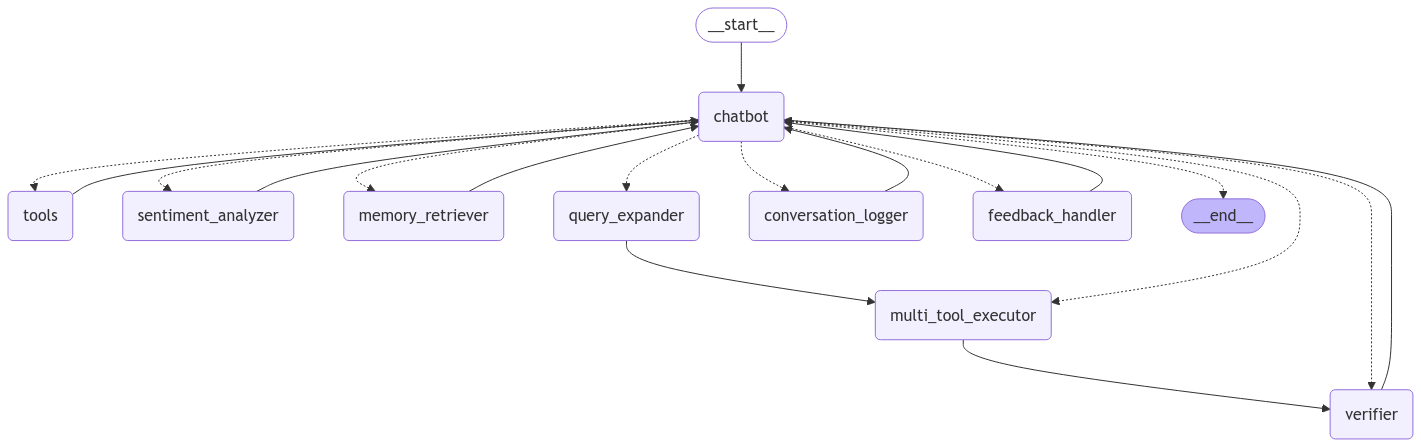

In [18]:
from IPython.display import Image, display


display(Image(graph.get_graph().draw_mermaid_png()))


In [26]:
from langchain.schema import HumanMessage

# 🔹 User Input
user_input = "Hi there! What is RLHF?"
max_iterations = 5  # ✅ Prevent looping by setting a limit

# 🔹 Run LangGraph with user input
events = graph.stream(
    {"messages": [HumanMessage(content=user_input)], "iteration_count": 0},  
    stream_mode="values"
)

iteration = 0  # ✅ Track iterations
final_keywords = ["Goodbye", "End of conversation", "Session ended", "Feedback received"]  # ✅ Stop on feedback

# 🔹 Print Each Event's Output (Enhanced Formatting)
print("\n" + "=" * 50)  
print("🧠 **Chatbot Conversation:**\n")

for event in events:
    if "messages" in event:
        last_message = event["messages"][-1].content  

        # ✅ Stop processing if response is empty
        if not last_message.strip():
            continue  

        # ✅ Detect multi-page summaries
        if "Page:" in last_message:
            print("\n🔹 **Detailed Information Retrieved:**\n")
            pages = last_message.split("Page:")  
            for page in pages[1:]:  
                lines = page.strip().split("\n")
                title = lines[0].strip()
                summary = "\n".join(lines[1:]).strip()
                print(f"📌 **{title}**\n{summary}\n")
                print("-" * 40)  

        else:
            print(f"💡 **AI Response:** {last_message}\n")  

        # ✅ Stop if max iterations are reached
        iteration += 1
        if iteration >= max_iterations:
            print("🛑 **Max iterations reached. Stopping execution.**")
            break  

        # ✅ Stop if the bot reaches a final response
        if any(phrase in last_message for phrase in final_keywords):
            print("✅ **Final response detected. Stopping execution.**")
            break  

print("=" * 50)  



🧠 **Chatbot Conversation:**

💡 **AI Response:** Hi there! What is RLHF?

💡 **AI Response:** Published: 2024-07-15
Title: Exploration-Driven Policy Optimization in RLHF: Theoretical Insights on Efficient Data Utilization
Authors: Yihan Du, Anna Winnicki, Gal Dalal, Shie Mannor, R. Srikant
Summary: Reinforcement Learning from Human Feedback (RLHF) has achieved impressive
empirical successes while relying on a small amount of human feedback. However,
there is limited theoretical justification for this phenomenon. Additionally,
most recent studies focus on value-based algorithms despite the recent
empirical successes of policy-based algorithms. In this work, we consider an
RLHF algorithm based on policy optimization (PO-RLHF). The algorithm is based
on the popular Policy Cover-Policy Gradient (PC-PG) algorithm, which assumes
knowledge of the reward function. In PO-RLHF, knowledge of the reward function
is not assumed, and the algorithm uses trajectory-based comparison feedback to
infer th

In [24]:
import pickle

# ✅ Save the graph structure (before compiling)
with open("graph.pkl", "wb") as f:
    pickle.dump(graph_builder, f)

print("✅ Graph structure saved successfully!")


AttributeError: Can't pickle local object '_add_messages_wrapper.<locals>._add_messages'